# Vectorization and JIT compilation in Python

#### Examples for the QuantEcon 2017 PhD workshops

[John Stachurski](http://johnstachurski.net)

In [1]:
import numpy as np
from numba import vectorize, jit, float64
from quantecon.util import tic, toc
import matplotlib.pyplot as plt

## Problem 1: A Time Series Model

Consider the time series model

$$ x_{t+1} = \alpha x_t (1 - x_t) $$

Let's set $\alpha = 4$

In [2]:
α = 4

Here's a typical time series:

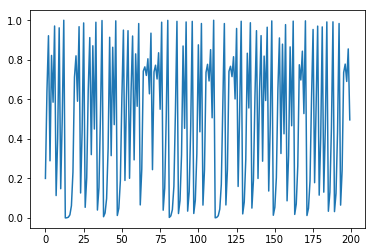

In [3]:
n = 200
x =  np.empty(n)
x[0] = 0.2
for t in range(n-1):
    x[t+1] = α * x[t] * (1 - x[t])
    
plt.plot(x)
plt.show()

Here's a function that simulates for `n` periods, starting from `x0`, and returns **only the final** value:

In [4]:
def quad(x0, n):
    x = x0
    for i in range(1, n):
        x = α * x * (1 - x)
    return x

Let's see how fast this runs:

In [5]:
n = 10_000_000

In [6]:
tic()
x = quad(0.2, n)
toc()

TOC: Elapsed: 1.1631062030792236 seconds.


1.1631062030792236

Now let's try this in FORTRAN.  

Note --- this step is intended to be a demo and will only execute if

* you have the file `fastquad.f90` in your pwd
* you have a FORTRAN compiler installed and modify the compilation code below appropriately

In [7]:
!cat fastquad.f90

In [8]:
!gfortran -O3 fastquad.f90

In [9]:
!./a.out

 last val =   0.46200166384322749     
 elapsed time =    3.5999999999999997E-002


Now let's do the same thing in Python using Numba's JIT compilation:

In [10]:
quad_jitted = jit(quad)

In [24]:
tic()
x = quad_jitted(0.2, n)
toc()

TOC: Elapsed: 0.03176760673522949 seconds.


0.03176760673522949

In [24]:
tic()
x = quad_jitted(0.2, n)
toc()

TOC: Elapsed: 0.03176760673522949 seconds.


0.03176760673522949

After JIT compilation, function execution speed is about the same as FORTRAN.

But remember, JIT compilation for Python is still limited --- see [here](http://numba.pydata.org/numba-doc/dev/reference/pysupported.html)

If these limitations frustrate you, then try Julia.

## Problem 2: Brute Force Optimization

The problem is to maximize the function 

$$ f(x, y) = \frac{\cos \left(x^2 + y^2 \right)}{1 + x^2 + y^2} + 1$$

using brute force --- searching over a grid of $(x, y)$ pairs.

In [12]:
def f(x, y):
    return np.cos(x**2 + y**2) / (1 + x**2 + y**2) + 1

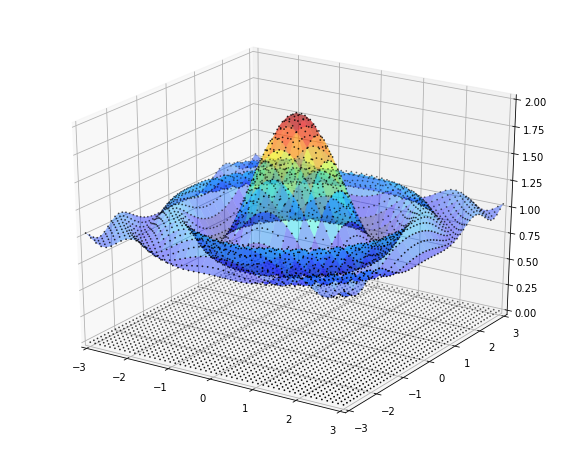

In [13]:

from mpl_toolkits.mplot3d.axes3d import Axes3D
from matplotlib import cm

gridsize = 50
gmin, gmax = -3, 3
xgrid = np.linspace(gmin, gmax, gridsize)
ygrid = xgrid
x, y = np.meshgrid(xgrid, ygrid)

# === plot value function === #
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(x,
                y,
                f(x, y),
                rstride=2, cstride=2,
                cmap=cm.jet,
                alpha=0.4,
                linewidth=0.05)


ax.scatter(x, y, c='k', s=0.6)

ax.scatter(x, y, f(x, y), c='k', s=0.6)

ax.view_init(25, -57)
ax.set_zlim(-0, 2.0)
ax.set_xlim(gmin, gmax)
ax.set_ylim(gmin, gmax)

plt.show()


### Vectorized code

In [14]:
grid = np.linspace(-3, 3, 10000)

In [15]:
x, y = np.meshgrid(grid, grid)

In [16]:
tic()
np.max(f(x, y))
toc()

TOC: Elapsed: 4.514950752258301 seconds.


4.514950752258301

### JITTed code

A jitted version

In [17]:
@jit
def compute_max():
    m = -np.inf
    for x in grid:
        for y in grid:
            z = np.cos(x**2 + y**2) / (1 + x**2 + y**2) + 1
            if z > m:
                m = z
    return m

In [18]:
compute_max()

1.999999819964011

In [19]:
tic()
compute_max()
toc()

TOC: Elapsed: 3.108513116836548 seconds.


3.108513116836548

Numba for vectorization with automatic parallelization - even faster:

In [20]:
@vectorize('float64(float64, float64)', target='parallel')
def f_par(x, y):
    return np.cos(x**2 + y**2) / (1 + x**2 + y**2) + 1

In [21]:
x, y = np.meshgrid(grid, grid)

np.max(f_par(x, y))

1.999999819964011

In [22]:
tic()
np.max(f_par(x, y))
toc()

TOC: Elapsed: 0.6686551570892334 seconds.


0.6686551570892334